In [1]:
from kaggle_environments import evaluate, make, utils

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

In [3]:
class DQN(nn.Module):
    
    #need input space and output space
    def __init__(self, num_states, num_actions):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=num_states, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=num_actions) # so num actions is gonna be wrong at some point cause you can't play in a certain position sometimes
        
    # t is input tensor
    def forward(self, t):
        # t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

In [4]:
# experience class
# create instances of experience objects that get stored in, and sampled from, the reply memory
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0 # keeps track of how many experiences we have added to memory
      
    # push method stores experiences in replay mem
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
            
        # if memory full, we overwrite the old memories
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    
    # returns a random sample of experiences
    # remember we need this to train the network
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    # can we sample from memory yet? ie we only have 2 experiences but our batch size is 50
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [7]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        
        
        legal_moves = [c for c in range(self.num_actions) if state.board[c] == 0]
        
        # explore
        if rate > random.random():
            # action = random.randrange(self.num_actions)
            action = random.choice(legal_moves)
            return torch.tensor(action).to(self.device) # explore, before had as torch.tensor([action]).to(self.device)
        
        #exploit
        else:
            # doing the torch.no_grad() before we pass data to the policy net
            # to turn off gradient tracking b/c we using model for inference, not training
            
            state = torch.tensor(state.board).float()
            with torch.no_grad():
#                 return policy_net(state).argmax(dim=1).to(self.device) # exploit
                #action = policy_net(state).argmax().to() # exploit
    
    
                estimatedqvals = policy_net(state) # just using policy net output
        
                # gotta make sure this doesn't pick an already full column, so beef up the legal column q-vals
                for move in legal_moves:
                    estimatedqvals[move] += 100


                return estimatedqvals.argmax().to(self.device)

In [8]:
class ConnectX():
    def __init__(self):
#         self.device = device
        self.env = make('connectx', debug=True)
        self.trainer = self.env.train([None, "random"])
        
        
#         self.env.reset()
#         self.done = False

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)
        
    
    
    def step(self, action):
        return self.trainer.step(action)
    
    
    def reset(self):
        return self.trainer.reset()

    def render(self):
        return self.env.render()
        #return self.env.render(**kwargs)

 
        
    # other methods
    def close(self):
        self.env.close()

    # should be like 7 or something, its the number of actions you can take
    def num_actions_available(self):
        return self.action_space.n # not just self.env.action_space.n cause env has none i guess
    
    def num_states(self):
        return self.observation_space.n # or just self.observation_space.n??

In [9]:
# this worked because the duration is exactly equal to the reward it gets 
def plot(values, moving_avg_period):
    plt.figure(1)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('reward')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    
    if is_ipython:
        display.clear_output(wait=True)
        
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [10]:
# tensor processing
def extract_tensors(experiences):
    
    # Convert batch of Experiences to Experience of batches, see below
    batch = Experience(*zip(*experiences))

    t1 = torch.stack(batch.state)
    t2 = torch.stack(batch.action)
    t3 = torch.stack(batch.reward)
    t4 = torch.stack(batch.next_state)

    return (t1,t2,t3,t4)

In [11]:
# Q value class - calculates the Q-vals

class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    # static methods - can call the methods without creating an instance of the class first
    
    # states and actions are the ones that are sampled from replay mem. returns predicted q-vals from policy net for those stat-action pairs
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    
    
    '''
    remember for each next state, we want to obtain the maximum q value we could get for
    that next state (across all the possible actions).
    For a DQN, that max q value will be predicted by the target net
    
    The final states: when an episode ends (in our case its when the screen is all black, ie its all 0)
        We want to know where these final states are (if any) b/c we don't want to pass them to target net to
        get a predicted q-val. Q-val for final states is 0 b/c agent won't recieve a reward once episode has ended
    
    '''
    @staticmethod
    
    # so hmmm I guess i'm not worried about selecting a final state here, or am i? so going to change this
    # all we really need is the right sied of bellman (given the next state, what is highest q value of all possible next options)
    def get_next(target_net, next_states):
        return target_net(next_states).max(dim=1)[0]
        
        # ok so here could easily write something to find if the next state is a final state (look if you fuck up and choose an extra col or you win). Or maybe is this just trying to filter out picking an already filled column?
        # either way i think its just trying to make it so we don't select a final state as a best possible next optino. but why not? aren't some final states good?
        # anf also aren't i gonna filter out stupid moves anyway?
        
        # so here they are finding anything where its all black (if the max of all the inpupts is 0, then its all 0s -> all black)
        
#         final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        
#         non_final_state_locations = (final_state_locations == False)# just an exact opposite of the final_state_locations
#         non_final_states = next_states[non_final_state_locations] # getting the value of those states
        
#         batch_size = next_states.shape[0]
#         values = torch.zeros(batch_size).to(QValues.device) # initializing tensor and sending to device
        
        # returns tensor with 0s for q-vals for final states, and target net's maximum predicted q-vals across all actions for each final state
#         values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()


In [12]:
# tune these hyperparameters to experiment with

batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

mydevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = ConnectX()
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, env.num_actions_available(), mydevice)
memory = ReplayMemory(memory_size)

policy_net = DQN(env.num_states(), env.num_actions_available()).to(mydevice)
target_net = DQN(env.num_states(), env.num_actions_available()).to(mydevice)

target_net.load_state_dict(policy_net.state_dict()) # setting the weights and biases to be the same as the policy net
target_net.eval() # tells pytorch that network is not in training mode, only used for inference
# lets try without these 2 things later

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

In [13]:
# testing block
episode_durations = []
env.reset()
state = env.reset()
# state = torch.tensor(state.board).float()
# print(state)

nactions = env.num_actions_available()


legalmoves = [c for c in range(nactions) if state.board[c] == 0]
action = random.choice(legalmoves)
action = torch.tensor(action).to(mydevice) # explore
print(action)


state = torch.tensor(state.board).float()
with torch.no_grad():
#   return policy_net(state).argmax(dim=1).to(self.device) # exploit
    estimatedqvals = policy_net(state) # exploit
    print(estimatedqvals)
    for move in legalmoves:
        estimatedqvals[move] += 100
    print(estimatedqvals)
    
    action = estimatedqvals.argmax().to(mydevice)
    print(action)


# 






tensor(6)
tensor([ 0.2051, -0.0528, -0.0435,  0.0954, -0.1155,  0.0948,  0.0638])
tensor([100.2051,  99.9472,  99.9566, 100.0954,  99.8845, 100.0948, 100.0638])
tensor(0)


KeyboardInterrupt: 

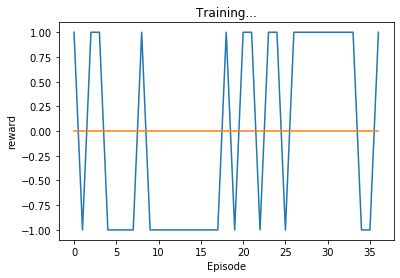

In [18]:
# training loop

episode_durations = []
episode_rewards = []

# implementation of algorithim
for episode in range(num_episodes):
    env.reset()
#     state = env.get_state() #why need?
    state = env.reset()
    done = False
    r = 0
    
    for timestep in count():
        action = agent.select_action(state, policy_net) # is this expecting state as a tensor...
        
        next_state, reward, done, info = env.step(action.item()) # item returns value of tensor, since action is a tensor, before had # obs, reward, done, _ = env.take_action(action) #this take_action is same as step, but just wrapps the reward in a tensor # reward = env.take_action(action)
        # env.render()
        
        # fix rewards
        if reward == 0:
            reward = -1
        elif reward == 0.5:
            reward = 0
        else:
            reward = 1
        r += reward
        
        # yeah so right now reward is just going to be 0 or 1, and i should just do it at end of episode. like no need to keep storing it
        # but then how will it train on a good move or not? can only evaluate at end...
        # cause most of the rewards in the experience buffer are just 0, so not very helpful for training...
        
    
    
#        memory.push(Experience(state, action, next_state, reward_tensor))
        memory.push(Experience(torch.tensor(state.board).float(), action, torch.tensor(next_state.board).float(), torch.tensor(reward, dtype=torch.float, device=mydevice))) # but why the [reward] and not just reward???
        state = next_state
        
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions) # returns q values for any state action pairs as predicted by the policy net, returned as a pytorch tensor
            
            # for each next state, we want to obtain the maximum q value (predicted by target net) among all possible next actions
            # This function will return the maximum q-values for the next states using using the best corresponding next actions
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards # calculating the target q-vals using the formula

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1)) # calc loss using mean squared error
            optimizer.zero_grad() # if we didn't zero out gradients, we would be accumulating gradients across all back prop runs.?????
            loss.backward() # computes gradient of loss wrt all weights and biases in the policy net
            optimizer.step() # updates the wrights and biases with the gradients that were computed when we called backward() 
            
            
        if done:
            episode_durations.append(timestep)
            episode_rewards.append(r)
            plot(episode_rewards, 100)
            
            # ok so these episode_durations are just basically the reward it got... since its directly the episode duration. 
            # let see what the other guy is plotting
            
            break
            
            
    # check to see if we need to update the target network (remember we set it to multiples of 10)
    if episode % target_update == 0: 
        target_net.load_state_dict(policy_net.state_dict())
        
env.close()

In [ ]:
experiences_test = memory.sample(50)
print(experiences_test)

In [ ]:
torch.tensor(0.5).float()

In [ ]:
# def extract_tensors(experiences):
    
#     # Convert batch of Experiences to Experience of batches, see below
#     batch = Experience(*zip(*experiences))

#     t1 = torch.cat(batch.state)
#     t2 = torch.cat(batch.action)
#     t3 = torch.cat(batch.reward)
#     t4 = torch.cat(batch.next_state)

#     return (t1,t2,t3,t4)

# next line is current_q_values = QValues.get_current(policy_net, states, actions)
#     def get_current(policy_net, states, actions):
#         return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1)) 
#     '''
#     remember for each next state, we want to obtain the maximum q value we could get for
#     that next state (across all the possible actions).
#     For a DQN, that max q value will be predicted by the target net
#     '''
    


# states, actions, rewards, next_states = extract_tensors(experiences)
# current_q_values = QValues.get_current(policy_net, states, actions) # returns q values for any state action pairs as predicted by the policy net, returned as a pytorch tensor

batch_test = Experience(*zip(*experiences_test))
print(batch_test)

# states_test1 = torch.cat(batch_test.state)
# print(states_test1)

states_test2 = torch.stack(batch_test.state)
print(states_test2)

actions_test = torch.stack(batch_test.action)
print(actions_test)

next_states_test = torch.stack(batch_test.next_state)
print(next_states_test)




In [ ]:
QValues.get_current(policy_net, states_test2, actions_test)

In [ ]:
batch_size = next_states_test.shape[0]
values = torch.zeros(batch_size).to(mydevice) # initializing tensor and sending to device

In [ ]:
values

In [ ]:
target_net(next_states_test)

In [ ]:
target_net(next_states_test).max(dim=1)[0]

In [ ]:


# returns tensor with 0s for q-vals for final states, and target net's maximum predicted q-vals across all actions for each final state
values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
return values

In [ ]:
qvals_test = torch.tensor([[1.0143],
        [1.0678]])

next_q_vals_test = torch.tensor([0.0631, 0.0623, 0.0639, 0.0626, 0.0624, 0.0627, 0.0624, 0.0625, 0.0623,
        0.0623, 0.0623, 0.0623, 0.0627, 0.0633, 0.0623, 0.0621, 0.0622, 0.0625,
        0.0624, 0.0623, 0.0628, 0.0000, 0.0625, 0.0620, 0.0622, 0.0622, 0.0624,
        0.0623, 0.0623, 0.0621, 0.0623, 0.0623, 0.0000, 0.0623, 0.0622, 0.0626,
        0.0628, 0.0623, 0.0000, 0.0626, 0.0624, 0.0622, 0.0623, 0.0626, 0.0626,
        0.0624, 0.0624, 0.0625, 0.0000, 0.0624, 0.0624, 0.0633, 0.0626, 0.0622,
        0.0623, 0.0624, 0.0624, 0.0627, 0.0627, 0.0623, 0.0623, 0.0623, 0.0631,
        0.0624, 0.0627, 0.0633, 0.0623, 0.0625, 0.0624, 0.0623, 0.0625, 0.0626,
        0.0623, 0.0624, 0.0623, 0.0626, 0.0628, 0.0622, 0.0623, 0.0624, 0.0625,
        0.0623, 0.0626, 0.0623, 0.0623, 0.0623, 0.0625, 0.0624, 0.0626, 0.0625,
        0.0631, 0.0628, 0.0619, 0.0623, 0.0624, 0.0623, 0.0624, 0.0623, 0.0623,
        0.0632, 0.0626, 0.0623, 0.0000, 0.0629, 0.0623, 0.0629, 0.0624, 0.0623,
        0.0624, 0.0623, 0.0624, 0.0624, 0.0624, 0.0625, 0.0625, 0.0623, 0.0623,
        0.0624, 0.0628, 0.0623, 0.0000, 0.0626, 0.0623, 0.0622, 0.0623, 0.0623,
        0.0625, 0.0626, 0.0624, 0.0623, 0.0633, 0.0624, 0.0623, 0.0620, 0.0625,
        0.0623, 0.0624, 0.0626, 0.0643, 0.0624, 0.0623, 0.0624, 0.0623, 0.0630,
        0.0625, 0.0626, 0.0624, 0.0625, 0.0624, 0.0622, 0.0623, 0.0624, 0.0625,
        0.0628, 0.0634, 0.0623, 0.0622, 0.0624, 0.0618, 0.0625, 0.0625, 0.0622,
        0.0623, 0.0627, 0.0622, 0.0622, 0.0624, 0.0643, 0.0623, 0.0623, 0.0626,
        0.0624, 0.0631, 0.0624, 0.0625, 0.0627, 0.0625, 0.0625, 0.0625, 0.0624,
        0.0624, 0.0000, 0.0625, 0.0621, 0.0623, 0.0625, 0.0624, 0.0626, 0.0623,
        0.0624, 0.0623, 0.0624, 0.0000, 0.0623, 0.0624, 0.0618, 0.0623, 0.0639,
        0.0623, 0.0626, 0.0000, 0.0621, 0.0639, 0.0624, 0.0623, 0.0623, 0.0623,
        0.0630, 0.0645, 0.0624, 0.0627, 0.0622, 0.0621, 0.0633, 0.0629, 0.0000,
        0.0623, 0.0623, 0.0626, 0.0626, 0.0627, 0.0624, 0.0625, 0.0625, 0.0628,
        0.0630, 0.0624, 0.0621, 0.0622, 0.0623, 0.0629, 0.0625, 0.0626, 0.0623,
        0.0624, 0.0623, 0.0624, 0.0000, 0.0631, 0.0624, 0.0622, 0.0623, 0.0624,
        0.0636, 0.0624, 0.0631, 0.0623, 0.0623, 0.0625, 0.0624, 0.0623, 0.0627,
        0.0623, 0.0624, 0.0000, 0.0624])

In [ ]:
qvals_test.size()

In [ ]:
next_q_vals_test.size()

In [ ]:
# use deeplizard DQN class and stuff, see if can get working with a gym conenct4?

# so with kaggles connectX class/env, I can easily train the agent against itself? doen't have to set that up?
# i.e --> self.trainer = self.env.train(self.pair)

# so do I need to import gym or nah...? can it easily train against itself?

# so the ConnectX class inherits the gym.env class... ok

# making it inherit the gym class ensures it will have the following methods:
#     step
#     reset
#     render
#     close
#     seed
# full implementations of kaggles Environment have implementations for step, reset, render, etc
# see here: https://github.com/Kaggle/kaggle-environments/blob/master/kaggle_environments/core.py

# ok..so what is kaggles env.make doing?

# has its own lightweight train method for training, ex
            # Training agent in first position (player 1) against the default random agent.
            trainer = env.train([None, "random"])
        
        
# ok so he's just modifying the connectX class, but why? i guess we will see




# ok so for now lets just see if i can successfully train something

# lets try to implement it using deeplizards DQN, and see if can train using it. Then, compare with that dudes on stuff like how 
# his training algo is slightly different, his hyperparms, and like how fast his takes

'''
so I think the part I was worried most about is handled, like how to train my network against a different agent. I guess when
we originally create the ConnectX() env we can just choose the trainer or something to be the negmax agent and train against that
and then i guess when we can beat that we can train against our current best agent...


ok so i realized that can't use:
    from collections import namedtuple
    from itertools import count
    
but I think i can re-organize it to do it. Also need to fix how i'm storing my observations/states? are they the same thing?

'''

In [ ]:
# this is kaggles connect4 env



from kaggle_environments import make
import gym

class ConnectX(gym.Env):
    def __init__(self):
        self.env = make("connectx", debug=True)
        self.trainer = self.env.train([None, "random"])
        
        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(config.columns * config.rows)

    def step(self, action):
        return self.trainer.step(action)
    
    def reset(self):
        return self.trainer.reset()
    
    def render(self, **kwargs):
        return self.env.render(**kwargs)
        
    
env = ConnectX()

done = False
obs = env.reset()
while not done:
    # Choose first available empty column as the action.
    action = [i for i in range(len(obs.board)) if obs.board[i] == 0][0]
    obs, reward, done, info = env.step(action)
env.render()

## create env

## hyperparameters

In [ ]:
# from deeplizard, comments are what other guy has
batch_size = 256 # 32
gamma = 0.999 # 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10 # guessing this is "copy step" = 25
memory_size = 100000
lr = 0.001 #.01
num_episodes = 1000 # episodes = 16000





# additions from other guy
copy_step = 25
hidden_units = [100, 200, 200, 100]

max_experiences = 10000
min_experiences = 100

# epsilon = 0.5        looks like these all correspond
# decay = 0.9999
# min_epsilon = 0.1


precision = 7